In [15]:
import numpy as np
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf

In [2]:
general_path = 'data/'
df = pd.read_csv(general_path + 'train.csv')
df.sample(5)

,image_id,label
19632,665859596.jpg,1
5099,1908512219.jpg,2
15170,3724849127.jpg,3
20464,815952257.jpg,3
15794,384188814.jpg,3


In [3]:
train_list = df.to_numpy()
image_list = train_list[:,0].astype(np.str)
label_list = train_list[:,1].astype(np.uint8)
print(image_list.dtype)
print(label_list.dtype)

<U14
uint8


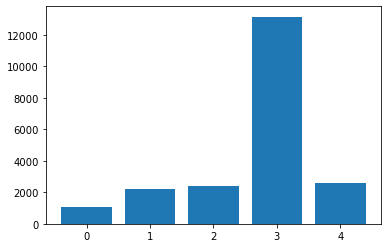

In [4]:
import matplotlib.pyplot as plt
plt.hist(label_list, bins=np.arange(6)-0.5, density=False, cumulative=False, histtype='bar', rwidth=0.8)
plt.xticks(range(5))
plt.show()

In [8]:
img_height = 456
img_width = 456

def get_leaf_data(image_list, label_list):
    for data in zip(image_list, label_list):
        img = tf.io.read_file(general_path + 'train_images/' + data[0].decode('utf-8'))
        img = tf.image.decode_jpeg(img, channels=3)
        resized_img = tf.image.resize(img, [img_height, img_width])
        
        label = data[1]    
        n_values = 5
        one_hot = tf.eye(n_values)[label]

        yield (tf.reshape(resized_img, [1, 456, 456, 3]) / 255, tf.reshape(one_hot, [1, 5]))

In [11]:
def get_leaf_data(image_list, label_list):
    height = 456
    width = 456
    for data in zip(image_list, label_list):
        """
            1) crop
            2) rotate90
            3) flip(horizon, vertical)
            4) brightness
            5) contrast
            6) hue
        """
        rc = np.random.randint(0, 300)
        rr = np.random.randint(0, 3)
        ori_img = tf.io.read_file(general_path + 'train_images/' + data[0].decode('utf-8'))
        ori_img = tf.image.decode_jpeg(ori_img, channels=3)
        img_height, img_width, _ = ori_img.shape
        img = tf.image.random_crop(ori_img, [img_height - rc, img_height - rc, 3])
        img = tf.image.rot90(img, k=rr)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_hue(img, 0.1)
        img = tf.image.random_brightness(img, 0.3)
        img = tf.image.random_contrast(img, 0.6, 1.8)
        img = tf.image.resize(img, [456, 456])
        img = tf.clip_by_value(img, 0, 255)
        
        label = data[1]    
        n_values = 5
        one_hot = tf.eye(n_values)[label]

        yield (tf.reshape(img, [1, height, width, 3]) / 255, tf.reshape(one_hot, [1, 5]))

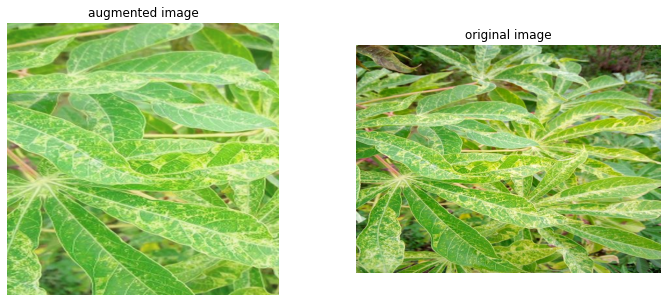

In [270]:
rc = np.random.randint(0, 300)
rr = np.random.randint(0, 3)
ori_img = tf.io.read_file(general_path + 'train_images/' + '85453943.jpg')
ori_img = tf.image.decode_jpeg(ori_img, channels=3)
img_height, img_width, _ = ori_img.shape
img = tf.image.random_crop(ori_img, [img_height - rc, img_height - rc, 3])
img = tf.image.rot90(img, k=rr)
img = tf.image.random_flip_left_right(img)
img = tf.image.random_flip_up_down(img)
img = tf.image.random_hue(img, 0.1)
img = tf.image.random_brightness(img, 0.15)
img = tf.image.random_contrast(img, 0.8, 1.5)
img = tf.image.resize(img, [456, 456])
img = tf.clip_by_value(img, 0, 255)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img / 255)
plt.title('augmented image')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(ori_img)
plt.title('original image')

plt.show()
# print(tf.math.reduce_max(augmented_img))
# print(tf.math.reduce_min(augmented_img))
# print(tf.math.maximum(tf.reshape(augmented_img, [456*456*3])))

In [113]:
inputs = tf.keras.layers.Input(shape=(456, 456, 3))
effnet = tf.keras.applications.EfficientNetB5(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=5,
    classifier_activation='softmax'
)(inputs)

In [27]:
effnet = tf.keras.layers.Dense(5, activation='softmax')(effnet)
# effnet.add(tf.keras.layers.Dense(5, activation='softmax'))
model = tf.keras.models.Model(inputs=inputs, outputs=effnet)
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.00005), metrics=['acc'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 456, 456, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 28,523,772
Trainable params: 28,351,029
Non-trainable params: 172,743
_________________________________________________________________


In [28]:
dataset = tf.data.Dataset.from_generator(get_leaf_data,
                                         output_types=(tf.float32, tf.float64),
                                         output_shapes=([None, 456, 456, 3], [None, 5]),
                                         args=(image_list, label_list))

In [29]:
model.fit(dataset, epochs=1)

   4703/Unknown - 786s 167ms/step - loss: 0.9871 - acc: 0.6472

KeyboardInterrupt: 